# 导入工具

In [171]:
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
%matplotlib inline
import pandas as pd
import numpy as np
import re
import time
from collections import defaultdict, Counter
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

1.14.0


# 查看数据 

In [2]:
raw_df = pd.read_csv('data/Reviews.csv')[:100]

In [3]:
raw_df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
95,96,B0019CW0HE,A1BFNM27629VAV,E. Triebe,0,0,5,1320105600,Good healthy dog food,I've been very pleased with the Natural Balanc...
96,97,B0019CW0HE,A18AAABCIJKC5Q,Rhiever,0,0,5,1303776000,Great dog food,My 1-1/2 year old basenji/jack russell mix lov...
97,98,B0019CW0HE,A3UII2114114PI,"FuNky Faja ""SiLkk""",0,0,5,1297296000,"Great allergy sensitive dog food, dogs love it",Our pup has experienced allergies in forms of ...
98,99,B0019CW0HE,ABZ9F0D94YK45,Amazon-tron 3000,0,0,5,1295308800,Perfect for our English Bulldog with Allergies,My English Bulldog had skin allergies the summ...
99,100,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...


In [4]:
raw_df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [80]:
df = raw_df.dropna()
df = raw_df.loc[:, ['Summary', 'Text']]

In [81]:
for i in range(5):
    print("Review #", i+1)
    print(df.Summary[i])
    print(df.Text[i])
    print()

Review # 1
Good Quality Dog Food
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review # 2
Not as Advertised
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review # 3
"Delight" says it all
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces 

# 准备数据

In [74]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

## 清洗

In [82]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    new_text = []
    for word in text.split():
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = ' '.join(new_text)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[>_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br', ' ',text)
    text = re.sub(r'><br', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text  = [word for word in text if not word in stops]
        text = ' '.join(text)
    return text

In [83]:
df['Cleaned_Summary'] = df.Summary.apply(clean_text, args=(False,))
df['Cleaned_Text'] = df.Text.apply(clean_text)

In [84]:
df.head(3)

,Summary,Text,Cleaned_Summary,Cleaned_Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,good quality dog food,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertised,product arrived labeled jumbo salted peanuts p...
2,"""Delight"" says it all",This is a confection that has been around a fe...,delight says it all,confection around centuries light pillowy citr...


## 统计 

In [85]:
# 统计单词字典 
word_dict_text = [word for sentence in df.Cleaned_Text for word in sentence.split()]
word_dict_summary = [word for sentence in df.Cleaned_Summary for word in sentence.split()]
dict_corpus = Counter(word_dict_summary) + Counter(word_dict_text)
dict_corpus.most_common(10), len(dict_corpus)

([('food', 69),
  ('good', 53),
  ('great', 53),
  ('dog', 42),
  ('like', 37),
  ('oatmeal', 35),
  ('taste', 28),
  ('product', 26),
  ('love', 23),
  ('instant', 22)],
 1479)

In [90]:
sorted(dict_corpus.items(), key=lambda x: x[1], reverse=1)

[('food', 69),
 ('good', 53),
 ('great', 53),
 ('dog', 42),
 ('like', 37),
 ('oatmeal', 35),
 ('taste', 28),
 ('product', 26),
 ('love', 23),
 ('instant', 22),
 ('sugar', 21),
 ('one', 21),
 ('would', 20),
 ('really', 19),
 ('little', 19),
 ('mccann', 19),
 ('use', 18),
 ('hot', 17),
 ('better', 17),
 ('natural', 17),
 ('time', 16),
 ('sauce', 15),
 ('flavor', 15),
 ('get', 15),
 ('water', 15),
 ('price', 14),
 ('buy', 14),
 ('coffee', 14),
 ('balance', 14),
 ('flavors', 14),
 ('twizzlers', 13),
 ('candy', 13),
 ('much', 13),
 ('dogs', 13),
 ('well', 13),
 ('make', 13),
 ('best', 12),
 ('for', 12),
 ('variety', 12),
 ('eat', 12),
 ('also', 12),
 ('taffy', 11),
 ('the', 11),
 ('regular', 11),
 ('free', 11),
 ('got', 11),
 ('brand', 11),
 ('could', 11),
 ('take', 11),
 ('store', 11),
 ('chocolate', 10),
 ('find', 10),
 ('tried', 10),
 ('amazon', 10),
 ('brown', 10),
 ('milk', 10),
 ('quality', 9),
 ('day', 9),
 ('tastes', 9),
 ('ever', 9),
 ('allergies', 9),
 ('bought', 9),
 ('found', 9)

In [55]:
# 使用预训练词向量：https://github.com/commonsense/conceptnet-numberbatch
embedding_index = defaultdict(str)
with open('data/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        value = line.split(' ')
        word = value[0]
        embedding = np.asarray(value[1:], dtype='float32')
        embedding_index[word] = embedding

In [130]:
threshold = 15
missing_words = []
for word, counts in dict_corpus.items():
    if counts > threshold:
        if word not in embedding_index:
            missing_words.append(word)
missing_ratio = round(len(missing_words) / len(dict_corpus), 4)
missing_words, missing_ratio

([], 0.0)

In [131]:
len([w for w in dict_corpus if dict_corpus[w] > threshold])

21

In [132]:
# 单词:索引映射
corpus_words = [w for w in dict_corpus.keys() if dict_corpus[w] > threshold]
vocab_to_index = {word: corpus_words.index(word) for word in corpus_words}
vocab_to_index

{'good': 0,
 'dog': 1,
 'food': 2,
 'great': 3,
 'hot': 4,
 'love': 5,
 'better': 6,
 'taste': 7,
 'product': 8,
 'instant': 9,
 'oatmeal': 10,
 'would': 11,
 'time': 12,
 'like': 13,
 'natural': 14,
 'sugar': 15,
 'one': 16,
 'really': 17,
 'use': 18,
 'little': 19,
 'mccann': 20}

In [133]:
padding_token = ['<UNK>', '<PAD>', '<EOS>', '<BOS>']
for token in padding_token:
    vocab_to_index[token] = len(vocab_to_index)

In [134]:
index_to_vocab = {value:key for key, value in vocab_to_index.items()}
usage_ratio = round(len(vocab_to_index) / len(dict_corpus), 4)
print(f"Total number of unique words: {len(dict_corpus)}")
print(f"Number of words we will use: {len(vocab_to_index)}")
print(f"Percent of words we will use: {usage_ratio * 100}%")

Total number of unique words: 1479
Number of words we will use: 25
Percent of words we will use: 1.69%


In [135]:
embedding_dim = 300 # same as pre-trained embedding
nb_words = len(vocab_to_index)

word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype='float32')
print(word_embedding_matrix.shape)

for word, index in vocab_to_index.items():
    if word in embedding_index:
        word_embedding_matrix[index] = embedding_index[word]
    else:  # padding token's random embedding
        new_embedding = np.array(np.random.rand(embedding_dim))
        word_embedding_matrix[index] = new_embedding
print(len(word_embedding_matrix))

(25, 300)
25


In [155]:
# 句子:索引映射
def sentence_to_int(texts, word_count=0, unk_count=0, eos=False):
    text_ints = []
    for sentence in texts:
        result = []
        split = sentence.split()
        word_count += len(split)
        for word in split:
            if word in vocab_to_index:
                result.append(vocab_to_index[word])
            else:
                result.append(vocab_to_index['<UNK>'])
                unk_count += 1
        if eos:
            result.append('<EOS>')
        text_ints.append(result)
    return text_ints, word_count, unk_count

In [159]:
result_sum, word_count_sum, unk_count_sum = sentence_to_int(df.Cleaned_Summary)
result_text, word_count_text, unk_count_text = sentence_to_int(df.Cleaned_Text, eos=True)
word_count = word_count_sum + word_count_text
unk_count = unk_count_sum + unk_count_text
unk_percent = round(unk_count / word_count, 4)
print(f"Total number of words in text and summary is: {word_count}")
print(f"Total number of unkonw token in text and summary is: {unk_count}")
print(f"Percent or words that are UNK is: {unk_percent * 100}%")

Total number of words in text and summary is: 3748
Total number of unkonw token in text and summary is: 3156
Percent or words that are UNK is: 84.2%


In [162]:
df.head(3)

,Summary,Text,Cleaned_Summary,Cleaned_Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,good quality dog food,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertised,product arrived labeled jumbo salted peanuts p...
2,"""Delight"" says it all",This is a confection that has been around a fe...,delight says it all,confection around centuries light pillowy citr...


In [185]:
df['Clean_Text_Length'] = df.Cleaned_Text.apply(lambda x: len(x.split()))
df['Clean_Summary_Length'] = df.Cleaned_Summary.apply(lambda x: len(x.split()))
df.describe()

,Clean_Text_Length,Clean_Summary_Length
count,100.000000,100.000000
mean,33.500000,3.980000
std,33.487673,2.534529
min,3.000000,1.000000
25%,13.000000,2.000000
50%,22.000000,3.000000
75%,40.000000,5.000000
max,216.000000,12.000000


22.0
103.24999999999999
159.57000000000028


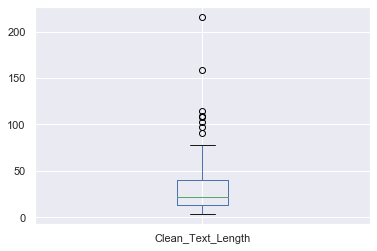

In [201]:
print(np.percentile(df.Clean_Text_Length, 50))
print(np.percentile(df.Clean_Text_Length, 95))
print(np.percentile(df.Clean_Text_Length, 99))
df.Clean_Text_Length.plot.box()
plt.show()

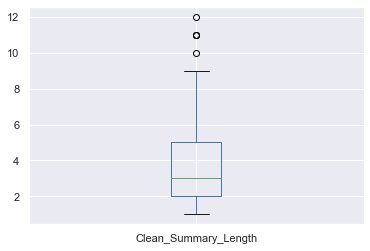

In [198]:
df.Clean_Summary_Length.plot.box()

# 建立训练模型

用的API太旧了。

# 摘要